# GAN

In [5]:
# train a generative adversarial network on a one-dimensional function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow
tensorflow.test.gpu_device_name()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy
# example of defining the generator model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import UpSampling1D

## Dataset

In [2]:
import scipy.io
# load phase dateset
def load_real_samples():
    d = scipy.io.loadmat('dataset')
    data_X = d['data_X']
    data_Y = d['data_Y'].ravel()
    
    #class abundances
    #print('N:', sum((data_Y == 0).ravel()))
    #print('S:', sum((data_Y == 1).ravel()))
    #print('P:', sum((data_Y == 2).ravel()))
    #print('T:', sum((data_Y == 3).ravel()))
    
    P_phase_indices = (data_Y == 2)
    X = data_X[P_phase_indices]
    
    means_in_channels = numpy.mean(X, axis=1, keepdims=True)
    X -= means_in_channels
    
    max_in_channels = numpy.max(numpy.max(numpy.abs(X), axis=1, keepdims=True), axis=2, keepdims=True)
    
    X /= max_in_channels
    
    return X

(6364, 400, 3)


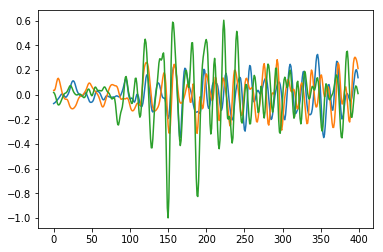

In [3]:
dataset = load_real_samples()
SAMPLES = dataset.shape[1]
CHANNELS = dataset.shape[2]
print(dataset.shape)
plt.plot(dataset[1005])

# Conv1D GAN

In [86]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = numpy.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X = numpy.reshape(X, (n_samples, SAMPLES, CHANNELS))
    # generate 'real' class labels (1)
    y = numpy.ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = numpy.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = numpy.zeros((n_samples, 1))
    return X, y


# define the standalone discriminator model
def define_discriminator(in_shape=(SAMPLES, CHANNELS)):
    model = Sequential()
    model.add(Conv1D(64, (3,), strides=(2,), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, (3,), strides=(2,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    DWNSMPLD = 100
    # foundation for 100 samples (downsampled 400 samples) x 3 channels
    n_nodes = 128 * DWNSMPLD # 128 is number of possible realizations   #100 is here 400 downsampled!!!
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((DWNSMPLD, 128)))
    # upsample to 200
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (3,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 400
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (3,), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv1D(3, (3,), activation='tanh', padding='same'))
    
    #model.add(Reshape((SAMPLES, CHANNELS)))
    
    return model    
    

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def visual_eval_generator(g_model, n_samples=10):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    fig = plt.figure(figsize=(8,16))
    for i in range(n_samples):
        ax = fig.add_subplot(n_samples, 1, i+1)
        ax.plot(X[i, :, :]) #, :])
    plt.tight_layout()
    plt.show()
    

#test of models
print('Generator:')
g_model = define_generator(100)
print(g_model.summary())

print()
print('Discriminator:')
d_model = define_discriminator(in_shape=(SAMPLES, CHANNELS))
print(d_model.summary())

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 12800)             1292800   
_________________________________________________________________
leaky_re_lu_194 (LeakyReLU)  (None, 12800)             0         
_________________________________________________________________
reshape_50 (Reshape)         (None, 100, 128)          0         
_________________________________________________________________
up_sampling1d_78 (UpSampling (None, 200, 128)          0         
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 200, 128)          49280     
_________________________________________________________________
leaky_re_lu_195 (LeakyReLU)  (None, 200, 128)          0         
_________________________________________________________________
up_sampling1d_79 (UpSampling (None, 400, 128)          0         

In [87]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator           
            X, y = numpy.vstack((X_real, X_fake)), numpy.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = numpy.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [88]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

>1, 1/24, d=0.694, g=0.694
>1, 2/24, d=0.696, g=0.686
>1, 3/24, d=0.690, g=0.681
>1, 4/24, d=0.691, g=0.674
>1, 5/24, d=0.690, g=0.670
>1, 6/24, d=0.687, g=0.667
>1, 7/24, d=0.681, g=0.673
>1, 8/24, d=0.682, g=0.681
>1, 9/24, d=0.673, g=0.691
>1, 10/24, d=0.672, g=0.695
>1, 11/24, d=0.668, g=0.691
>1, 12/24, d=0.669, g=0.677
>1, 13/24, d=0.679, g=0.655
>1, 14/24, d=0.689, g=0.629
>1, 15/24, d=0.706, g=0.600
>1, 16/24, d=0.723, g=0.579
>1, 17/24, d=0.737, g=0.567
>1, 18/24, d=0.740, g=0.568
>1, 19/24, d=0.739, g=0.589
>1, 20/24, d=0.725, g=0.614
>1, 21/24, d=0.703, g=0.658
>1, 22/24, d=0.686, g=0.702
>1, 23/24, d=0.672, g=0.729
>1, 24/24, d=0.649, g=0.770
>2, 1/24, d=0.650, g=0.781
>2, 2/24, d=0.651, g=0.778
>2, 3/24, d=0.663, g=0.751
>2, 4/24, d=0.678, g=0.716
>2, 5/24, d=0.694, g=0.686
>2, 6/24, d=0.709, g=0.661
>2, 7/24, d=0.726, g=0.628
>2, 8/24, d=0.748, g=0.603
>2, 9/24, d=0.779, g=0.561
>2, 10/24, d=0.813, g=0.527
>2, 11/24, d=0.845, g=0.508
>2, 12/24, d=0.849, g=0.508
>2, 13/24,

>2, 20/24, d=0.705, g=0.816
>2, 21/24, d=0.691, g=0.849
>2, 22/24, d=0.692, g=0.871
>2, 23/24, d=0.681, g=0.876
>2, 24/24, d=0.688, g=0.868
>3, 1/24, d=0.686, g=0.846
>3, 2/24, d=0.710, g=0.806
>3, 3/24, d=0.715, g=0.767
>3, 4/24, d=0.730, g=0.728
>3, 5/24, d=0.737, g=0.700
>3, 6/24, d=0.746, g=0.680
>3, 7/24, d=0.753, g=0.670
>3, 8/24, d=0.751, g=0.661
>3, 9/24, d=0.752, g=0.654
>3, 10/24, d=0.755, g=0.651
>3, 11/24, d=0.752, g=0.650
>3, 12/24, d=0.750, g=0.647
>3, 13/24, d=0.746, g=0.647
>3, 14/24, d=0.745, g=0.646
>3, 15/24, d=0.748, g=0.646
>3, 16/24, d=0.741, g=0.651
>3, 17/24, d=0.740, g=0.648
>3, 18/24, d=0.739, g=0.648
>3, 19/24, d=0.737, g=0.650
>3, 20/24, d=0.737, g=0.650
>3, 21/24, d=0.737, g=0.648
>3, 22/24, d=0.730, g=0.653
>3, 23/24, d=0.732, g=0.650
>3, 24/24, d=0.729, g=0.648
>4, 1/24, d=0.728, g=0.649
>4, 2/24, d=0.725, g=0.645
>4, 3/24, d=0.727, g=0.645
>4, 4/24, d=0.727, g=0.646
>4, 5/24, d=0.733, g=0.643
>4, 6/24, d=0.727, g=0.642
>4, 7/24, d=0.729, g=0.642
>4, 8/24

>4, 16/24, d=0.721, g=0.633
>4, 17/24, d=0.726, g=0.634
>4, 18/24, d=0.726, g=0.633
>4, 19/24, d=0.723, g=0.636
>4, 20/24, d=0.726, g=0.636
>4, 21/24, d=0.724, g=0.630
>4, 22/24, d=0.722, g=0.634
>4, 23/24, d=0.724, g=0.633
>4, 24/24, d=0.727, g=0.635
>5, 1/24, d=0.725, g=0.637
>5, 2/24, d=0.722, g=0.639
>5, 3/24, d=0.723, g=0.632
>5, 4/24, d=0.726, g=0.635
>5, 5/24, d=0.719, g=0.638
>5, 6/24, d=0.726, g=0.636
>5, 7/24, d=0.722, g=0.640
>5, 8/24, d=0.727, g=0.643
>5, 9/24, d=0.723, g=0.639
>5, 10/24, d=0.722, g=0.641
>5, 11/24, d=0.722, g=0.643
>5, 12/24, d=0.717, g=0.646
>5, 13/24, d=0.725, g=0.648
>5, 14/24, d=0.723, g=0.643
>5, 15/24, d=0.721, g=0.648
>5, 16/24, d=0.721, g=0.649
>5, 17/24, d=0.726, g=0.649
>5, 18/24, d=0.725, g=0.648
>5, 19/24, d=0.722, g=0.652
>5, 20/24, d=0.720, g=0.657
>5, 21/24, d=0.719, g=0.652
>5, 22/24, d=0.719, g=0.656
>5, 23/24, d=0.724, g=0.662
>5, 24/24, d=0.727, g=0.662
>6, 1/24, d=0.721, g=0.662
>6, 2/24, d=0.724, g=0.662
>6, 3/24, d=0.721, g=0.663
>6, 

>6, 12/24, d=0.722, g=0.682
>6, 13/24, d=0.722, g=0.679
>6, 14/24, d=0.721, g=0.679
>6, 15/24, d=0.719, g=0.681
>6, 16/24, d=0.722, g=0.682
>6, 17/24, d=0.720, g=0.682
>6, 18/24, d=0.721, g=0.687
>6, 19/24, d=0.717, g=0.687
>6, 20/24, d=0.722, g=0.686
>6, 21/24, d=0.718, g=0.691
>6, 22/24, d=0.720, g=0.688
>6, 23/24, d=0.725, g=0.689
>6, 24/24, d=0.719, g=0.693
>7, 1/24, d=0.725, g=0.696
>7, 2/24, d=0.720, g=0.697
>7, 3/24, d=0.720, g=0.694
>7, 4/24, d=0.721, g=0.697
>7, 5/24, d=0.718, g=0.695
>7, 6/24, d=0.724, g=0.700
>7, 7/24, d=0.720, g=0.700
>7, 8/24, d=0.717, g=0.703
>7, 9/24, d=0.720, g=0.702
>7, 10/24, d=0.720, g=0.700
>7, 11/24, d=0.721, g=0.702
>7, 12/24, d=0.722, g=0.700
>7, 13/24, d=0.721, g=0.700
>7, 14/24, d=0.722, g=0.699
>7, 15/24, d=0.722, g=0.699
>7, 16/24, d=0.723, g=0.702
>7, 17/24, d=0.720, g=0.702
>7, 18/24, d=0.722, g=0.700
>7, 19/24, d=0.720, g=0.703
>7, 20/24, d=0.721, g=0.699
>7, 21/24, d=0.721, g=0.697
>7, 22/24, d=0.722, g=0.698
>7, 23/24, d=0.716, g=0.698
>

>8, 8/24, d=0.715, g=0.692
>8, 9/24, d=0.719, g=0.690
>8, 10/24, d=0.721, g=0.689
>8, 11/24, d=0.718, g=0.690
>8, 12/24, d=0.720, g=0.689
>8, 13/24, d=0.718, g=0.687
>8, 14/24, d=0.716, g=0.688
>8, 15/24, d=0.717, g=0.686
>8, 16/24, d=0.713, g=0.686
>8, 17/24, d=0.714, g=0.684
>8, 18/24, d=0.715, g=0.684
>8, 19/24, d=0.714, g=0.684
>8, 20/24, d=0.715, g=0.682
>8, 21/24, d=0.714, g=0.683
>8, 22/24, d=0.712, g=0.680
>8, 23/24, d=0.718, g=0.680
>8, 24/24, d=0.713, g=0.679
>9, 1/24, d=0.715, g=0.678
>9, 2/24, d=0.717, g=0.677
>9, 3/24, d=0.713, g=0.676
>9, 4/24, d=0.713, g=0.675
>9, 5/24, d=0.711, g=0.674
>9, 6/24, d=0.713, g=0.676
>9, 7/24, d=0.712, g=0.675
>9, 8/24, d=0.711, g=0.672
>9, 9/24, d=0.709, g=0.674
>9, 10/24, d=0.712, g=0.674
>9, 11/24, d=0.711, g=0.671
>9, 12/24, d=0.711, g=0.673
>9, 13/24, d=0.709, g=0.670
>9, 14/24, d=0.712, g=0.671
>9, 15/24, d=0.709, g=0.670
>9, 16/24, d=0.709, g=0.669
>9, 17/24, d=0.709, g=0.669
>9, 18/24, d=0.709, g=0.668
>9, 19/24, d=0.708, g=0.669
>9,

>10, 4/24, d=0.710, g=0.668
>10, 5/24, d=0.709, g=0.669
>10, 6/24, d=0.709, g=0.666
>10, 7/24, d=0.709, g=0.667
>10, 8/24, d=0.707, g=0.667
>10, 9/24, d=0.712, g=0.667
>10, 10/24, d=0.709, g=0.670
>10, 11/24, d=0.709, g=0.668
>10, 12/24, d=0.710, g=0.668
>10, 13/24, d=0.709, g=0.669
>10, 14/24, d=0.710, g=0.671
>10, 15/24, d=0.709, g=0.670
>10, 16/24, d=0.711, g=0.671
>10, 17/24, d=0.709, g=0.672
>10, 18/24, d=0.709, g=0.673
>10, 19/24, d=0.710, g=0.673
>10, 20/24, d=0.707, g=0.676
>10, 21/24, d=0.710, g=0.677
>10, 22/24, d=0.707, g=0.677
>10, 23/24, d=0.708, g=0.675
>10, 24/24, d=0.706, g=0.679
>11, 1/24, d=0.711, g=0.678
>11, 2/24, d=0.707, g=0.680
>11, 3/24, d=0.710, g=0.678
>11, 4/24, d=0.709, g=0.681
>11, 5/24, d=0.709, g=0.680
>11, 6/24, d=0.710, g=0.681
>11, 7/24, d=0.707, g=0.681
>11, 8/24, d=0.709, g=0.683
>11, 9/24, d=0.707, g=0.685
>11, 10/24, d=0.709, g=0.683
>11, 11/24, d=0.707, g=0.685
>11, 12/24, d=0.706, g=0.683
>11, 13/24, d=0.706, g=0.687
>11, 14/24, d=0.706, g=0.686


>11, 24/24, d=0.706, g=0.689
>12, 1/24, d=0.706, g=0.688
>12, 2/24, d=0.707, g=0.691
>12, 3/24, d=0.707, g=0.689
>12, 4/24, d=0.708, g=0.689
>12, 5/24, d=0.707, g=0.690
>12, 6/24, d=0.708, g=0.689
>12, 7/24, d=0.708, g=0.689
>12, 8/24, d=0.706, g=0.687
>12, 9/24, d=0.703, g=0.686
>12, 10/24, d=0.706, g=0.685
>12, 11/24, d=0.706, g=0.686
>12, 12/24, d=0.706, g=0.687
>12, 13/24, d=0.707, g=0.686
>12, 14/24, d=0.706, g=0.685
>12, 15/24, d=0.704, g=0.687
>12, 16/24, d=0.706, g=0.684
>12, 17/24, d=0.707, g=0.685
>12, 18/24, d=0.705, g=0.685
>12, 19/24, d=0.709, g=0.685
>12, 20/24, d=0.704, g=0.683
>12, 21/24, d=0.705, g=0.686
>12, 22/24, d=0.705, g=0.684
>12, 23/24, d=0.705, g=0.684
>12, 24/24, d=0.704, g=0.683
>13, 1/24, d=0.703, g=0.682
>13, 2/24, d=0.706, g=0.682
>13, 3/24, d=0.704, g=0.684
>13, 4/24, d=0.704, g=0.684
>13, 5/24, d=0.706, g=0.683
>13, 6/24, d=0.705, g=0.684
>13, 7/24, d=0.706, g=0.684
>13, 8/24, d=0.705, g=0.683
>13, 9/24, d=0.704, g=0.683
>13, 10/24, d=0.702, g=0.684
>13

>13, 20/24, d=0.703, g=0.686
>13, 21/24, d=0.703, g=0.686
>13, 22/24, d=0.702, g=0.686
>13, 23/24, d=0.701, g=0.688
>13, 24/24, d=0.702, g=0.684
>14, 1/24, d=0.703, g=0.686
>14, 2/24, d=0.701, g=0.688
>14, 3/24, d=0.702, g=0.687
>14, 4/24, d=0.701, g=0.687
>14, 5/24, d=0.702, g=0.689
>14, 6/24, d=0.701, g=0.690
>14, 7/24, d=0.702, g=0.690
>14, 8/24, d=0.699, g=0.691
>14, 9/24, d=0.699, g=0.690
>14, 10/24, d=0.702, g=0.690
>14, 11/24, d=0.700, g=0.689
>14, 12/24, d=0.700, g=0.690
>14, 13/24, d=0.700, g=0.692
>14, 14/24, d=0.701, g=0.692
>14, 15/24, d=0.701, g=0.692
>14, 16/24, d=0.699, g=0.693
>14, 17/24, d=0.702, g=0.694
>14, 18/24, d=0.702, g=0.692
>14, 19/24, d=0.699, g=0.694
>14, 20/24, d=0.698, g=0.694
>14, 21/24, d=0.699, g=0.696
>14, 22/24, d=0.702, g=0.694
>14, 23/24, d=0.697, g=0.696
>14, 24/24, d=0.701, g=0.695
>15, 1/24, d=0.702, g=0.697
>15, 2/24, d=0.702, g=0.696
>15, 3/24, d=0.700, g=0.696
>15, 4/24, d=0.701, g=0.699
>15, 5/24, d=0.701, g=0.698
>15, 6/24, d=0.700, g=0.698


>15, 16/24, d=0.702, g=0.700
>15, 17/24, d=0.701, g=0.701
>15, 18/24, d=0.699, g=0.703
>15, 19/24, d=0.700, g=0.703
>15, 20/24, d=0.699, g=0.702
>15, 21/24, d=0.698, g=0.704
>15, 22/24, d=0.701, g=0.705
>15, 23/24, d=0.702, g=0.702
>15, 24/24, d=0.699, g=0.700
>16, 1/24, d=0.698, g=0.701
>16, 2/24, d=0.698, g=0.704
>16, 3/24, d=0.698, g=0.703
>16, 4/24, d=0.697, g=0.705
>16, 5/24, d=0.700, g=0.703
>16, 6/24, d=0.699, g=0.701
>16, 7/24, d=0.701, g=0.700
>16, 8/24, d=0.702, g=0.701
>16, 9/24, d=0.700, g=0.702
>16, 10/24, d=0.700, g=0.703
>16, 11/24, d=0.700, g=0.704
>16, 12/24, d=0.700, g=0.703
>16, 13/24, d=0.701, g=0.701
>16, 14/24, d=0.702, g=0.697
>16, 15/24, d=0.702, g=0.699
>16, 16/24, d=0.702, g=0.700
>16, 17/24, d=0.698, g=0.703
>16, 18/24, d=0.699, g=0.706
>16, 19/24, d=0.698, g=0.706
>16, 20/24, d=0.697, g=0.704
>16, 21/24, d=0.700, g=0.699
>16, 22/24, d=0.701, g=0.695
>16, 23/24, d=0.703, g=0.696
>16, 24/24, d=0.702, g=0.701
>17, 1/24, d=0.700, g=0.707
>17, 2/24, d=0.696, g=0.

>17, 12/24, d=0.694, g=0.710
>17, 13/24, d=0.699, g=0.701
>17, 14/24, d=0.703, g=0.695
>17, 15/24, d=0.707, g=0.691
>17, 16/24, d=0.707, g=0.694
>17, 17/24, d=0.704, g=0.700
>17, 18/24, d=0.700, g=0.708
>17, 19/24, d=0.698, g=0.714
>17, 20/24, d=0.696, g=0.714
>17, 21/24, d=0.696, g=0.709
>17, 22/24, d=0.701, g=0.702
>17, 23/24, d=0.702, g=0.697
>17, 24/24, d=0.704, g=0.695
>18, 1/24, d=0.703, g=0.694
>18, 2/24, d=0.703, g=0.698
>18, 3/24, d=0.700, g=0.702
>18, 4/24, d=0.697, g=0.704
>18, 5/24, d=0.697, g=0.706
>18, 6/24, d=0.698, g=0.705
>18, 7/24, d=0.699, g=0.702
>18, 8/24, d=0.699, g=0.697
>18, 9/24, d=0.702, g=0.694
>18, 10/24, d=0.702, g=0.692
>18, 11/24, d=0.702, g=0.690
>18, 12/24, d=0.701, g=0.692
>18, 13/24, d=0.701, g=0.695
>18, 14/24, d=0.698, g=0.697
>18, 15/24, d=0.697, g=0.698
>18, 16/24, d=0.698, g=0.700
>18, 17/24, d=0.697, g=0.697
>18, 18/24, d=0.697, g=0.694
>18, 19/24, d=0.700, g=0.692
>18, 20/24, d=0.701, g=0.691
>18, 21/24, d=0.700, g=0.691
>18, 22/24, d=0.700, g=

>19, 8/24, d=0.701, g=0.689
>19, 9/24, d=0.699, g=0.692
>19, 10/24, d=0.698, g=0.695
>19, 11/24, d=0.698, g=0.697
>19, 12/24, d=0.697, g=0.700
>19, 13/24, d=0.699, g=0.696
>19, 14/24, d=0.699, g=0.693
>19, 15/24, d=0.705, g=0.688
>19, 16/24, d=0.706, g=0.690
>19, 17/24, d=0.705, g=0.694
>19, 18/24, d=0.701, g=0.703
>19, 19/24, d=0.696, g=0.713
>19, 20/24, d=0.696, g=0.718
>19, 21/24, d=0.694, g=0.712
>19, 22/24, d=0.696, g=0.706
>19, 23/24, d=0.701, g=0.698
>19, 24/24, d=0.704, g=0.693
>20, 1/24, d=0.708, g=0.690
>20, 2/24, d=0.706, g=0.693
>20, 3/24, d=0.704, g=0.696
>20, 4/24, d=0.700, g=0.705
>20, 5/24, d=0.697, g=0.713
>20, 6/24, d=0.695, g=0.718
>20, 7/24, d=0.695, g=0.720
>20, 8/24, d=0.695, g=0.715
>20, 9/24, d=0.696, g=0.708
>20, 10/24, d=0.699, g=0.701
>20, 11/24, d=0.702, g=0.696
>20, 12/24, d=0.702, g=0.696
>20, 13/24, d=0.703, g=0.697
>20, 14/24, d=0.702, g=0.701
>20, 15/24, d=0.700, g=0.707
>20, 16/24, d=0.700, g=0.706
>20, 17/24, d=0.697, g=0.708
>20, 18/24, d=0.698, g=0.

>21, 4/24, d=0.698, g=0.697
>21, 5/24, d=0.698, g=0.697
>21, 6/24, d=0.700, g=0.695
>21, 7/24, d=0.699, g=0.694
>21, 8/24, d=0.699, g=0.693
>21, 9/24, d=0.700, g=0.691
>21, 10/24, d=0.699, g=0.692
>21, 11/24, d=0.698, g=0.692
>21, 12/24, d=0.699, g=0.692
>21, 13/24, d=0.697, g=0.693
>21, 14/24, d=0.697, g=0.693
>21, 15/24, d=0.697, g=0.692
>21, 16/24, d=0.698, g=0.692
>21, 17/24, d=0.696, g=0.692
>21, 18/24, d=0.696, g=0.693
>21, 19/24, d=0.696, g=0.692
>21, 20/24, d=0.697, g=0.693
>21, 21/24, d=0.696, g=0.693
>21, 22/24, d=0.696, g=0.690
>21, 23/24, d=0.697, g=0.689
>21, 24/24, d=0.698, g=0.689
>22, 1/24, d=0.696, g=0.688
>22, 2/24, d=0.698, g=0.688
>22, 3/24, d=0.699, g=0.688
>22, 4/24, d=0.698, g=0.689
>22, 5/24, d=0.698, g=0.688
>22, 6/24, d=0.698, g=0.689
>22, 7/24, d=0.696, g=0.691
>22, 8/24, d=0.695, g=0.692
>22, 9/24, d=0.695, g=0.696
>22, 10/24, d=0.696, g=0.694
>22, 11/24, d=0.696, g=0.693
>22, 12/24, d=0.697, g=0.693
>22, 13/24, d=0.697, g=0.691
>22, 14/24, d=0.697, g=0.690


>22, 24/24, d=0.694, g=0.700
>23, 1/24, d=0.697, g=0.698
>23, 2/24, d=0.695, g=0.699
>23, 3/24, d=0.697, g=0.698
>23, 4/24, d=0.697, g=0.701
>23, 5/24, d=0.697, g=0.702
>23, 6/24, d=0.696, g=0.704
>23, 7/24, d=0.695, g=0.704
>23, 8/24, d=0.695, g=0.709
>23, 9/24, d=0.694, g=0.706
>23, 10/24, d=0.695, g=0.707
>23, 11/24, d=0.697, g=0.704
>23, 12/24, d=0.699, g=0.700
>23, 13/24, d=0.698, g=0.699
>23, 14/24, d=0.699, g=0.698
>23, 15/24, d=0.698, g=0.697
>23, 16/24, d=0.696, g=0.701
>23, 17/24, d=0.697, g=0.707
>23, 18/24, d=0.694, g=0.712
>23, 19/24, d=0.693, g=0.715
>23, 20/24, d=0.692, g=0.715
>23, 21/24, d=0.693, g=0.714
>23, 22/24, d=0.696, g=0.710
>23, 23/24, d=0.696, g=0.707
>23, 24/24, d=0.698, g=0.704
>24, 1/24, d=0.698, g=0.702
>24, 2/24, d=0.700, g=0.700
>24, 3/24, d=0.700, g=0.702
>24, 4/24, d=0.698, g=0.702
>24, 5/24, d=0.699, g=0.702
>24, 6/24, d=0.698, g=0.701
>24, 7/24, d=0.698, g=0.703
>24, 8/24, d=0.696, g=0.702
>24, 9/24, d=0.697, g=0.702
>24, 10/24, d=0.695, g=0.702
>24

>24, 20/24, d=0.699, g=0.696
>24, 21/24, d=0.700, g=0.695
>24, 22/24, d=0.700, g=0.695
>24, 23/24, d=0.698, g=0.694
>24, 24/24, d=0.698, g=0.697
>25, 1/24, d=0.697, g=0.698
>25, 2/24, d=0.697, g=0.698
>25, 3/24, d=0.696, g=0.699
>25, 4/24, d=0.695, g=0.700
>25, 5/24, d=0.693, g=0.700
>25, 6/24, d=0.694, g=0.699
>25, 7/24, d=0.694, g=0.699
>25, 8/24, d=0.695, g=0.697
>25, 9/24, d=0.696, g=0.697
>25, 10/24, d=0.696, g=0.696
>25, 11/24, d=0.697, g=0.695
>25, 12/24, d=0.697, g=0.693
>25, 13/24, d=0.697, g=0.692
>25, 14/24, d=0.697, g=0.693
>25, 15/24, d=0.698, g=0.692
>25, 16/24, d=0.698, g=0.693
>25, 17/24, d=0.697, g=0.693
>25, 18/24, d=0.697, g=0.697
>25, 19/24, d=0.698, g=0.697
>25, 20/24, d=0.697, g=0.699
>25, 21/24, d=0.695, g=0.702
>25, 22/24, d=0.694, g=0.704
>25, 23/24, d=0.695, g=0.705
>25, 24/24, d=0.694, g=0.707
>26, 1/24, d=0.693, g=0.708
>26, 2/24, d=0.695, g=0.705
>26, 3/24, d=0.695, g=0.702
>26, 4/24, d=0.698, g=0.699
>26, 5/24, d=0.699, g=0.696
>26, 6/24, d=0.699, g=0.697


>26, 16/24, d=0.695, g=0.709
>26, 17/24, d=0.694, g=0.711
>26, 18/24, d=0.694, g=0.710
>26, 19/24, d=0.694, g=0.712
>26, 20/24, d=0.693, g=0.714
>26, 21/24, d=0.695, g=0.711
>26, 22/24, d=0.696, g=0.710
>26, 23/24, d=0.696, g=0.706
>26, 24/24, d=0.699, g=0.703
>27, 1/24, d=0.698, g=0.701
>27, 2/24, d=0.698, g=0.701
>27, 3/24, d=0.700, g=0.702
>27, 4/24, d=0.698, g=0.704
>27, 5/24, d=0.696, g=0.707
>27, 6/24, d=0.696, g=0.709
>27, 7/24, d=0.693, g=0.712
>27, 8/24, d=0.692, g=0.715
>27, 9/24, d=0.692, g=0.715
>27, 10/24, d=0.692, g=0.714
>27, 11/24, d=0.693, g=0.710
>27, 12/24, d=0.694, g=0.708
>27, 13/24, d=0.697, g=0.704
>27, 14/24, d=0.697, g=0.701
>27, 15/24, d=0.698, g=0.697
>27, 16/24, d=0.699, g=0.698
>27, 17/24, d=0.697, g=0.697
>27, 18/24, d=0.699, g=0.697
>27, 19/24, d=0.699, g=0.699
>27, 20/24, d=0.697, g=0.700
>27, 21/24, d=0.695, g=0.704
>27, 22/24, d=0.694, g=0.707
>27, 23/24, d=0.694, g=0.707
>27, 24/24, d=0.692, g=0.708
>28, 1/24, d=0.692, g=0.707
>28, 2/24, d=0.694, g=0.

>28, 12/24, d=0.695, g=0.699
>28, 13/24, d=0.696, g=0.699
>28, 14/24, d=0.693, g=0.703
>28, 15/24, d=0.691, g=0.704
>28, 16/24, d=0.693, g=0.703
>28, 17/24, d=0.692, g=0.702
>28, 18/24, d=0.693, g=0.701
>28, 19/24, d=0.694, g=0.698
>28, 20/24, d=0.695, g=0.694
>28, 21/24, d=0.697, g=0.691
>28, 22/24, d=0.698, g=0.689
>28, 23/24, d=0.698, g=0.687
>28, 24/24, d=0.699, g=0.685
>29, 1/24, d=0.700, g=0.687
>29, 2/24, d=0.698, g=0.690
>29, 3/24, d=0.696, g=0.694
>29, 4/24, d=0.695, g=0.701
>29, 5/24, d=0.692, g=0.708
>29, 6/24, d=0.689, g=0.714
>29, 7/24, d=0.688, g=0.716
>29, 8/24, d=0.688, g=0.714
>29, 9/24, d=0.690, g=0.710
>29, 10/24, d=0.693, g=0.703
>29, 11/24, d=0.696, g=0.697
>29, 12/24, d=0.699, g=0.690
>29, 13/24, d=0.704, g=0.685
>29, 14/24, d=0.705, g=0.682
>29, 15/24, d=0.705, g=0.680
>29, 16/24, d=0.706, g=0.686
>29, 17/24, d=0.702, g=0.694
>29, 18/24, d=0.697, g=0.706
>29, 19/24, d=0.692, g=0.719
>29, 20/24, d=0.689, g=0.730
>29, 21/24, d=0.683, g=0.735
>29, 22/24, d=0.684, g=

>30, 8/24, d=0.695, g=0.723
>30, 9/24, d=0.693, g=0.726
>30, 10/24, d=0.691, g=0.730
>30, 11/24, d=0.692, g=0.726
>30, 12/24, d=0.695, g=0.721
>30, 13/24, d=0.697, g=0.714
>30, 14/24, d=0.700, g=0.711
>30, 15/24, d=0.704, g=0.709
>30, 16/24, d=0.702, g=0.711
>30, 17/24, d=0.699, g=0.718
>30, 18/24, d=0.697, g=0.724
>30, 19/24, d=0.692, g=0.732
>30, 20/24, d=0.691, g=0.733
>30, 21/24, d=0.691, g=0.732
>30, 22/24, d=0.692, g=0.725
>30, 23/24, d=0.696, g=0.717
>30, 24/24, d=0.698, g=0.709
>31, 1/24, d=0.702, g=0.701
>31, 2/24, d=0.705, g=0.695
>31, 3/24, d=0.706, g=0.690
>31, 4/24, d=0.706, g=0.690
>31, 5/24, d=0.707, g=0.690
>31, 6/24, d=0.704, g=0.694
>31, 7/24, d=0.702, g=0.700
>31, 8/24, d=0.698, g=0.708
>31, 9/24, d=0.695, g=0.717
>31, 10/24, d=0.690, g=0.725
>31, 11/24, d=0.689, g=0.729
>31, 12/24, d=0.688, g=0.728
>31, 13/24, d=0.690, g=0.725
>31, 14/24, d=0.690, g=0.722
>31, 15/24, d=0.693, g=0.713
>31, 16/24, d=0.695, g=0.706
>31, 17/24, d=0.699, g=0.701
>31, 18/24, d=0.701, g=0.

>32, 4/24, d=0.695, g=0.696
>32, 5/24, d=0.694, g=0.699
>32, 6/24, d=0.692, g=0.702
>32, 7/24, d=0.692, g=0.703
>32, 8/24, d=0.690, g=0.703
>32, 9/24, d=0.692, g=0.702
>32, 10/24, d=0.692, g=0.702
>32, 11/24, d=0.694, g=0.700
>32, 12/24, d=0.693, g=0.697
>32, 13/24, d=0.694, g=0.694
>32, 14/24, d=0.695, g=0.692
>32, 15/24, d=0.695, g=0.690
>32, 16/24, d=0.696, g=0.687
>32, 17/24, d=0.697, g=0.686
>32, 18/24, d=0.698, g=0.685
>32, 19/24, d=0.698, g=0.683
>32, 20/24, d=0.698, g=0.683
>32, 21/24, d=0.697, g=0.682
>32, 22/24, d=0.697, g=0.683
>32, 23/24, d=0.696, g=0.682
>32, 24/24, d=0.698, g=0.682
>33, 1/24, d=0.696, g=0.683
>33, 2/24, d=0.695, g=0.683
>33, 3/24, d=0.695, g=0.685
>33, 4/24, d=0.695, g=0.687
>33, 5/24, d=0.694, g=0.687
>33, 6/24, d=0.694, g=0.691
>33, 7/24, d=0.693, g=0.692
>33, 8/24, d=0.692, g=0.693
>33, 9/24, d=0.692, g=0.693
>33, 10/24, d=0.691, g=0.695
>33, 11/24, d=0.692, g=0.695
>33, 12/24, d=0.692, g=0.695
>33, 13/24, d=0.695, g=0.693
>33, 14/24, d=0.694, g=0.690


>33, 24/24, d=0.699, g=0.701
>34, 1/24, d=0.696, g=0.714
>34, 2/24, d=0.690, g=0.724
>34, 3/24, d=0.688, g=0.731
>34, 4/24, d=0.686, g=0.736
>34, 5/24, d=0.686, g=0.734
>34, 6/24, d=0.686, g=0.732
>34, 7/24, d=0.689, g=0.727
>34, 8/24, d=0.692, g=0.719
>34, 9/24, d=0.696, g=0.715
>34, 10/24, d=0.696, g=0.709
>34, 11/24, d=0.699, g=0.707
>34, 12/24, d=0.700, g=0.706
>34, 13/24, d=0.700, g=0.703
>34, 14/24, d=0.699, g=0.704
>34, 15/24, d=0.697, g=0.707
>34, 16/24, d=0.698, g=0.709
>34, 17/24, d=0.696, g=0.714
>34, 18/24, d=0.696, g=0.715
>34, 19/24, d=0.694, g=0.721
>34, 20/24, d=0.692, g=0.723
>34, 21/24, d=0.691, g=0.725
>34, 22/24, d=0.691, g=0.727
>34, 23/24, d=0.691, g=0.728
>34, 24/24, d=0.690, g=0.727
>35, 1/24, d=0.692, g=0.728
>35, 2/24, d=0.692, g=0.725
>35, 3/24, d=0.692, g=0.721
>35, 4/24, d=0.694, g=0.721
>35, 5/24, d=0.694, g=0.716
>35, 6/24, d=0.695, g=0.713
>35, 7/24, d=0.696, g=0.711
>35, 8/24, d=0.696, g=0.707
>35, 9/24, d=0.698, g=0.704
>35, 10/24, d=0.698, g=0.702
>35

>35, 20/24, d=0.696, g=0.687
>35, 21/24, d=0.698, g=0.687
>35, 22/24, d=0.697, g=0.686
>35, 23/24, d=0.696, g=0.686
>35, 24/24, d=0.696, g=0.687
>36, 1/24, d=0.696, g=0.688
>36, 2/24, d=0.695, g=0.687
>36, 3/24, d=0.694, g=0.688
>36, 4/24, d=0.695, g=0.689
>36, 5/24, d=0.693, g=0.689
>36, 6/24, d=0.693, g=0.690
>36, 7/24, d=0.693, g=0.689
>36, 8/24, d=0.692, g=0.690
>36, 9/24, d=0.692, g=0.691
>36, 10/24, d=0.692, g=0.690
>36, 11/24, d=0.691, g=0.690
>36, 12/24, d=0.692, g=0.690
>36, 13/24, d=0.691, g=0.690
>36, 14/24, d=0.691, g=0.689
>36, 15/24, d=0.690, g=0.689
>36, 16/24, d=0.690, g=0.688
>36, 17/24, d=0.691, g=0.686
>36, 18/24, d=0.691, g=0.687
>36, 19/24, d=0.690, g=0.685
>36, 20/24, d=0.691, g=0.684
>36, 21/24, d=0.691, g=0.683
>36, 22/24, d=0.691, g=0.681
>36, 23/24, d=0.691, g=0.680
>36, 24/24, d=0.692, g=0.681
>37, 1/24, d=0.692, g=0.678
>37, 2/24, d=0.693, g=0.676
>37, 3/24, d=0.694, g=0.675
>37, 4/24, d=0.693, g=0.673
>37, 5/24, d=0.695, g=0.673
>37, 6/24, d=0.695, g=0.672


>37, 16/24, d=0.693, g=0.685
>37, 17/24, d=0.691, g=0.689
>37, 18/24, d=0.691, g=0.694
>37, 19/24, d=0.690, g=0.697
>37, 20/24, d=0.689, g=0.696
>37, 21/24, d=0.691, g=0.695
>37, 22/24, d=0.692, g=0.693
>37, 23/24, d=0.695, g=0.688
>37, 24/24, d=0.696, g=0.685
>38, 1/24, d=0.701, g=0.680
>38, 2/24, d=0.704, g=0.677
>38, 3/24, d=0.706, g=0.676
>38, 4/24, d=0.707, g=0.677
>38, 5/24, d=0.709, g=0.675
>38, 6/24, d=0.709, g=0.678
>38, 7/24, d=0.707, g=0.687
>38, 8/24, d=0.704, g=0.696
>38, 9/24, d=0.701, g=0.709
>38, 10/24, d=0.695, g=0.725
>38, 11/24, d=0.690, g=0.739
>38, 12/24, d=0.686, g=0.748
>38, 13/24, d=0.684, g=0.755
>38, 14/24, d=0.683, g=0.759
>38, 15/24, d=0.684, g=0.753
>38, 16/24, d=0.685, g=0.750
>38, 17/24, d=0.689, g=0.743
>38, 18/24, d=0.692, g=0.740
>38, 19/24, d=0.694, g=0.736
>38, 20/24, d=0.696, g=0.734
>38, 21/24, d=0.696, g=0.736
>38, 22/24, d=0.694, g=0.738
>38, 23/24, d=0.692, g=0.740
>38, 24/24, d=0.691, g=0.744
>39, 1/24, d=0.692, g=0.746
>39, 2/24, d=0.689, g=0.

>39, 12/24, d=0.703, g=0.703
>39, 13/24, d=0.704, g=0.698
>39, 14/24, d=0.704, g=0.695
>39, 15/24, d=0.705, g=0.694
>39, 16/24, d=0.703, g=0.690
>39, 17/24, d=0.704, g=0.692
>39, 18/24, d=0.703, g=0.690
>39, 19/24, d=0.703, g=0.691
>39, 20/24, d=0.701, g=0.692
>39, 21/24, d=0.700, g=0.695
>39, 22/24, d=0.698, g=0.698
>39, 23/24, d=0.697, g=0.699
>39, 24/24, d=0.696, g=0.701
>40, 1/24, d=0.695, g=0.703
>40, 2/24, d=0.694, g=0.705
>40, 3/24, d=0.693, g=0.706
>40, 4/24, d=0.693, g=0.705
>40, 5/24, d=0.693, g=0.705
>40, 6/24, d=0.693, g=0.704
>40, 7/24, d=0.694, g=0.702
>40, 8/24, d=0.693, g=0.700
>40, 9/24, d=0.695, g=0.699
>40, 10/24, d=0.696, g=0.697
>40, 11/24, d=0.696, g=0.695
>40, 12/24, d=0.697, g=0.694
>40, 13/24, d=0.697, g=0.691
>40, 14/24, d=0.698, g=0.688
>40, 15/24, d=0.697, g=0.687
>40, 16/24, d=0.697, g=0.686
>40, 17/24, d=0.696, g=0.683
>40, 18/24, d=0.697, g=0.682
>40, 19/24, d=0.698, g=0.680
>40, 20/24, d=0.697, g=0.680
>40, 21/24, d=0.697, g=0.678
>40, 22/24, d=0.697, g=

>41, 8/24, d=0.694, g=0.670
>41, 9/24, d=0.695, g=0.669
>41, 10/24, d=0.694, g=0.670
>41, 11/24, d=0.693, g=0.670
>41, 12/24, d=0.692, g=0.670
>41, 13/24, d=0.692, g=0.670
>41, 14/24, d=0.692, g=0.670
>41, 15/24, d=0.691, g=0.670
>41, 16/24, d=0.691, g=0.670
>41, 17/24, d=0.691, g=0.670
>41, 18/24, d=0.691, g=0.670
>41, 19/24, d=0.690, g=0.670
>41, 20/24, d=0.690, g=0.671
>41, 21/24, d=0.690, g=0.671
>41, 22/24, d=0.688, g=0.672
>41, 23/24, d=0.689, g=0.673
>41, 24/24, d=0.689, g=0.673
>42, 1/24, d=0.688, g=0.674
>42, 2/24, d=0.687, g=0.674
>42, 3/24, d=0.687, g=0.674
>42, 4/24, d=0.685, g=0.674
>42, 5/24, d=0.687, g=0.675
>42, 6/24, d=0.686, g=0.676
>42, 7/24, d=0.685, g=0.676
>42, 8/24, d=0.685, g=0.675
>42, 9/24, d=0.685, g=0.675
>42, 10/24, d=0.685, g=0.675
>42, 11/24, d=0.685, g=0.674
>42, 12/24, d=0.685, g=0.672
>42, 13/24, d=0.685, g=0.669
>42, 14/24, d=0.687, g=0.667
>42, 15/24, d=0.690, g=0.662
>42, 16/24, d=0.693, g=0.659
>42, 17/24, d=0.695, g=0.653
>42, 18/24, d=0.700, g=0.

>43, 4/24, d=0.689, g=0.734
>43, 5/24, d=0.682, g=0.750
>43, 6/24, d=0.679, g=0.759
>43, 7/24, d=0.678, g=0.761
>43, 8/24, d=0.680, g=0.752
>43, 9/24, d=0.687, g=0.740
>43, 10/24, d=0.695, g=0.728
>43, 11/24, d=0.703, g=0.716
>43, 12/24, d=0.710, g=0.706
>43, 13/24, d=0.715, g=0.704
>43, 14/24, d=0.715, g=0.713
>43, 15/24, d=0.709, g=0.728
>43, 16/24, d=0.701, g=0.746
>43, 17/24, d=0.692, g=0.766
>43, 18/24, d=0.685, g=0.784
>43, 19/24, d=0.681, g=0.793
>43, 20/24, d=0.681, g=0.790
>43, 21/24, d=0.683, g=0.780
>43, 22/24, d=0.687, g=0.767
>43, 23/24, d=0.692, g=0.754
>43, 24/24, d=0.694, g=0.745
>44, 1/24, d=0.696, g=0.736
>44, 2/24, d=0.701, g=0.732
>44, 3/24, d=0.701, g=0.726
>44, 4/24, d=0.703, g=0.720
>44, 5/24, d=0.703, g=0.717
>44, 6/24, d=0.702, g=0.714
>44, 7/24, d=0.705, g=0.713
>44, 8/24, d=0.705, g=0.712
>44, 9/24, d=0.704, g=0.713
>44, 10/24, d=0.703, g=0.713
>44, 11/24, d=0.701, g=0.713
>44, 12/24, d=0.700, g=0.714
>44, 13/24, d=0.699, g=0.714
>44, 14/24, d=0.698, g=0.713


>44, 24/24, d=0.697, g=0.703
>45, 1/24, d=0.698, g=0.702
>45, 2/24, d=0.697, g=0.701
>45, 3/24, d=0.698, g=0.700
>45, 4/24, d=0.698, g=0.698
>45, 5/24, d=0.697, g=0.697
>45, 6/24, d=0.697, g=0.695
>45, 7/24, d=0.697, g=0.694
>45, 8/24, d=0.698, g=0.693
>45, 9/24, d=0.698, g=0.692
>45, 10/24, d=0.697, g=0.691
>45, 11/24, d=0.696, g=0.691
>45, 12/24, d=0.697, g=0.688
>45, 13/24, d=0.697, g=0.688
>45, 14/24, d=0.697, g=0.687
>45, 15/24, d=0.697, g=0.686
>45, 16/24, d=0.697, g=0.685
>45, 17/24, d=0.698, g=0.684
>45, 18/24, d=0.697, g=0.683
>45, 19/24, d=0.697, g=0.682
>45, 20/24, d=0.697, g=0.681
>45, 21/24, d=0.696, g=0.680
>45, 22/24, d=0.697, g=0.680
>45, 23/24, d=0.697, g=0.679
>45, 24/24, d=0.697, g=0.678
>46, 1/24, d=0.698, g=0.677
>46, 2/24, d=0.697, g=0.677
>46, 3/24, d=0.697, g=0.676
>46, 4/24, d=0.697, g=0.676
>46, 5/24, d=0.697, g=0.675
>46, 6/24, d=0.696, g=0.675
>46, 7/24, d=0.697, g=0.675
>46, 8/24, d=0.696, g=0.674
>46, 9/24, d=0.697, g=0.674
>46, 10/24, d=0.696, g=0.673
>46

>46, 20/24, d=0.694, g=0.677
>46, 21/24, d=0.693, g=0.678
>46, 22/24, d=0.692, g=0.679
>46, 23/24, d=0.691, g=0.679
>46, 24/24, d=0.691, g=0.680
>47, 1/24, d=0.690, g=0.681
>47, 2/24, d=0.690, g=0.681
>47, 3/24, d=0.690, g=0.681
>47, 4/24, d=0.690, g=0.680
>47, 5/24, d=0.691, g=0.680
>47, 6/24, d=0.689, g=0.679
>47, 7/24, d=0.691, g=0.679
>47, 8/24, d=0.690, g=0.679
>47, 9/24, d=0.691, g=0.679
>47, 10/24, d=0.690, g=0.677
>47, 11/24, d=0.691, g=0.677
>47, 12/24, d=0.691, g=0.676
>47, 13/24, d=0.690, g=0.675
>47, 14/24, d=0.691, g=0.675
>47, 15/24, d=0.691, g=0.675
>47, 16/24, d=0.691, g=0.674
>47, 17/24, d=0.691, g=0.673
>47, 18/24, d=0.692, g=0.672
>47, 19/24, d=0.691, g=0.672
>47, 20/24, d=0.691, g=0.671
>47, 21/24, d=0.692, g=0.670
>47, 22/24, d=0.691, g=0.670
>47, 23/24, d=0.691, g=0.670
>47, 24/24, d=0.692, g=0.670
>48, 1/24, d=0.691, g=0.669
>48, 2/24, d=0.693, g=0.668
>48, 3/24, d=0.692, g=0.669
>48, 4/24, d=0.693, g=0.668
>48, 5/24, d=0.692, g=0.668
>48, 6/24, d=0.694, g=0.668


>48, 16/24, d=0.691, g=0.670
>48, 17/24, d=0.692, g=0.672
>48, 18/24, d=0.691, g=0.673
>48, 19/24, d=0.691, g=0.672
>48, 20/24, d=0.691, g=0.673
>48, 21/24, d=0.692, g=0.675
>48, 22/24, d=0.691, g=0.675
>48, 23/24, d=0.691, g=0.676
>48, 24/24, d=0.691, g=0.676
>49, 1/24, d=0.692, g=0.676
>49, 2/24, d=0.692, g=0.676
>49, 3/24, d=0.692, g=0.676
>49, 4/24, d=0.693, g=0.676
>49, 5/24, d=0.694, g=0.675
>49, 6/24, d=0.695, g=0.673
>49, 7/24, d=0.695, g=0.670
>49, 8/24, d=0.696, g=0.669
>49, 9/24, d=0.700, g=0.668
>49, 10/24, d=0.701, g=0.665
>49, 11/24, d=0.703, g=0.665
>49, 12/24, d=0.704, g=0.663
>49, 13/24, d=0.705, g=0.665
>49, 14/24, d=0.705, g=0.666
>49, 15/24, d=0.704, g=0.668
>49, 16/24, d=0.704, g=0.670
>49, 17/24, d=0.704, g=0.677
>49, 18/24, d=0.703, g=0.680
>49, 19/24, d=0.700, g=0.687
>49, 20/24, d=0.699, g=0.694
>49, 21/24, d=0.696, g=0.701
>49, 22/24, d=0.693, g=0.707
>49, 23/24, d=0.692, g=0.712
>49, 24/24, d=0.692, g=0.716
>50, 1/24, d=0.691, g=0.719
>50, 2/24, d=0.689, g=0.

>50, 12/24, d=0.698, g=0.720
>50, 13/24, d=0.696, g=0.728
>50, 14/24, d=0.694, g=0.734
>50, 15/24, d=0.693, g=0.741
>50, 16/24, d=0.689, g=0.747
>50, 17/24, d=0.688, g=0.752
>50, 18/24, d=0.686, g=0.754
>50, 19/24, d=0.687, g=0.754
>50, 20/24, d=0.685, g=0.753
>50, 21/24, d=0.686, g=0.748
>50, 22/24, d=0.687, g=0.746
>50, 23/24, d=0.690, g=0.740
>50, 24/24, d=0.692, g=0.732
>51, 1/24, d=0.694, g=0.727
>51, 2/24, d=0.697, g=0.721
>51, 3/24, d=0.697, g=0.717
>51, 4/24, d=0.699, g=0.713
>51, 5/24, d=0.699, g=0.711
>51, 6/24, d=0.699, g=0.710
>51, 7/24, d=0.700, g=0.709
>51, 8/24, d=0.700, g=0.710
>51, 9/24, d=0.699, g=0.710
>51, 10/24, d=0.698, g=0.711
>51, 11/24, d=0.697, g=0.711
>51, 12/24, d=0.697, g=0.711
>51, 13/24, d=0.696, g=0.710
>51, 14/24, d=0.696, g=0.709
>51, 15/24, d=0.696, g=0.707
>51, 16/24, d=0.695, g=0.707
>51, 17/24, d=0.695, g=0.705
>51, 18/24, d=0.695, g=0.704
>51, 19/24, d=0.696, g=0.702
>51, 20/24, d=0.698, g=0.699
>51, 21/24, d=0.696, g=0.697
>51, 22/24, d=0.697, g=

>52, 8/24, d=0.699, g=0.686
>52, 9/24, d=0.698, g=0.687
>52, 10/24, d=0.698, g=0.686
>52, 11/24, d=0.698, g=0.686
>52, 12/24, d=0.698, g=0.686
>52, 13/24, d=0.697, g=0.686
>52, 14/24, d=0.697, g=0.687
>52, 15/24, d=0.697, g=0.687
>52, 16/24, d=0.696, g=0.687
>52, 17/24, d=0.696, g=0.686
>52, 18/24, d=0.696, g=0.687
>52, 19/24, d=0.695, g=0.687
>52, 20/24, d=0.696, g=0.687
>52, 21/24, d=0.696, g=0.686
>52, 22/24, d=0.695, g=0.686
>52, 23/24, d=0.694, g=0.686
>52, 24/24, d=0.694, g=0.685
>53, 1/24, d=0.694, g=0.685
>53, 2/24, d=0.693, g=0.685
>53, 3/24, d=0.692, g=0.684
>53, 4/24, d=0.693, g=0.683
>53, 5/24, d=0.693, g=0.684
>53, 6/24, d=0.692, g=0.684
>53, 7/24, d=0.693, g=0.683
>53, 8/24, d=0.693, g=0.682
>53, 9/24, d=0.692, g=0.682
>53, 10/24, d=0.692, g=0.682
>53, 11/24, d=0.692, g=0.682
>53, 12/24, d=0.692, g=0.681
>53, 13/24, d=0.692, g=0.681
>53, 14/24, d=0.692, g=0.680
>53, 15/24, d=0.693, g=0.680
>53, 16/24, d=0.692, g=0.680
>53, 17/24, d=0.693, g=0.680
>53, 18/24, d=0.692, g=0.

>54, 4/24, d=0.692, g=0.681
>54, 5/24, d=0.691, g=0.681
>54, 6/24, d=0.690, g=0.680
>54, 7/24, d=0.690, g=0.681
>54, 8/24, d=0.690, g=0.682
>54, 9/24, d=0.691, g=0.681
>54, 10/24, d=0.691, g=0.682
>54, 11/24, d=0.690, g=0.681
>54, 12/24, d=0.690, g=0.681
>54, 13/24, d=0.691, g=0.681
>54, 14/24, d=0.690, g=0.680
>54, 15/24, d=0.692, g=0.679
>54, 16/24, d=0.693, g=0.678
>54, 17/24, d=0.693, g=0.676
>54, 18/24, d=0.694, g=0.675
>54, 19/24, d=0.695, g=0.672
>54, 20/24, d=0.697, g=0.671
>54, 21/24, d=0.697, g=0.668
>54, 22/24, d=0.699, g=0.668
>54, 23/24, d=0.701, g=0.668
>54, 24/24, d=0.702, g=0.669
>55, 1/24, d=0.702, g=0.671
>55, 2/24, d=0.699, g=0.676
>55, 3/24, d=0.697, g=0.684
>55, 4/24, d=0.693, g=0.691
>55, 5/24, d=0.690, g=0.700
>55, 6/24, d=0.686, g=0.708
>55, 7/24, d=0.682, g=0.717
>55, 8/24, d=0.681, g=0.722
>55, 9/24, d=0.681, g=0.722
>55, 10/24, d=0.682, g=0.717
>55, 11/24, d=0.686, g=0.710
>55, 12/24, d=0.690, g=0.700
>55, 13/24, d=0.695, g=0.693
>55, 14/24, d=0.698, g=0.685


>55, 24/24, d=0.691, g=0.723
>56, 1/24, d=0.687, g=0.734
>56, 2/24, d=0.686, g=0.739
>56, 3/24, d=0.688, g=0.741
>56, 4/24, d=0.689, g=0.736
>56, 5/24, d=0.689, g=0.734
>56, 6/24, d=0.692, g=0.730
>56, 7/24, d=0.693, g=0.731
>56, 8/24, d=0.694, g=0.733
>56, 9/24, d=0.694, g=0.735
>56, 10/24, d=0.692, g=0.734
>56, 11/24, d=0.693, g=0.736
>56, 12/24, d=0.691, g=0.737
>56, 13/24, d=0.693, g=0.738
>56, 14/24, d=0.693, g=0.737
>56, 15/24, d=0.694, g=0.736
>56, 16/24, d=0.694, g=0.734
>56, 17/24, d=0.695, g=0.729
>56, 18/24, d=0.697, g=0.726
>56, 19/24, d=0.700, g=0.722
>56, 20/24, d=0.700, g=0.718
>56, 21/24, d=0.700, g=0.713
>56, 22/24, d=0.700, g=0.710
>56, 23/24, d=0.701, g=0.710
>56, 24/24, d=0.702, g=0.708
>57, 1/24, d=0.702, g=0.708
>57, 2/24, d=0.700, g=0.709
>57, 3/24, d=0.700, g=0.709
>57, 4/24, d=0.698, g=0.710
>57, 5/24, d=0.697, g=0.713
>57, 6/24, d=0.696, g=0.717
>57, 7/24, d=0.693, g=0.719
>57, 8/24, d=0.693, g=0.722
>57, 9/24, d=0.691, g=0.726
>57, 10/24, d=0.692, g=0.726
>57

>57, 20/24, d=0.696, g=0.710
>57, 21/24, d=0.695, g=0.707
>57, 22/24, d=0.696, g=0.705
>57, 23/24, d=0.696, g=0.701
>57, 24/24, d=0.698, g=0.700
>58, 1/24, d=0.697, g=0.699
>58, 2/24, d=0.697, g=0.697
>58, 3/24, d=0.697, g=0.694
>58, 4/24, d=0.698, g=0.693
>58, 5/24, d=0.698, g=0.693
>58, 6/24, d=0.697, g=0.692
>58, 7/24, d=0.697, g=0.692
>58, 8/24, d=0.699, g=0.692
>58, 9/24, d=0.697, g=0.691
>58, 10/24, d=0.697, g=0.690
>58, 11/24, d=0.697, g=0.691
>58, 12/24, d=0.696, g=0.690
>58, 13/24, d=0.696, g=0.691
>58, 14/24, d=0.695, g=0.691
>58, 15/24, d=0.696, g=0.691
>58, 16/24, d=0.696, g=0.690
>58, 17/24, d=0.694, g=0.691
>58, 18/24, d=0.694, g=0.691
>58, 19/24, d=0.695, g=0.691
>58, 20/24, d=0.694, g=0.692
>58, 21/24, d=0.695, g=0.691
>58, 22/24, d=0.693, g=0.692
>58, 23/24, d=0.693, g=0.691
>58, 24/24, d=0.693, g=0.692
>59, 1/24, d=0.692, g=0.692
>59, 2/24, d=0.693, g=0.692
>59, 3/24, d=0.693, g=0.691
>59, 4/24, d=0.693, g=0.691
>59, 5/24, d=0.692, g=0.691
>59, 6/24, d=0.692, g=0.690


>59, 16/24, d=0.691, g=0.685
>59, 17/24, d=0.691, g=0.684
>59, 18/24, d=0.692, g=0.683
>59, 19/24, d=0.693, g=0.682
>59, 20/24, d=0.692, g=0.682
>59, 21/24, d=0.692, g=0.681
>59, 22/24, d=0.693, g=0.679
>59, 23/24, d=0.692, g=0.678
>59, 24/24, d=0.693, g=0.679
>60, 1/24, d=0.693, g=0.678
>60, 2/24, d=0.694, g=0.676
>60, 3/24, d=0.693, g=0.675
>60, 4/24, d=0.693, g=0.675
>60, 5/24, d=0.693, g=0.673
>60, 6/24, d=0.694, g=0.672
>60, 7/24, d=0.694, g=0.673
>60, 8/24, d=0.695, g=0.671
>60, 9/24, d=0.695, g=0.671
>60, 10/24, d=0.695, g=0.669
>60, 11/24, d=0.695, g=0.670
>60, 12/24, d=0.695, g=0.669
>60, 13/24, d=0.696, g=0.669
>60, 14/24, d=0.697, g=0.668
>60, 15/24, d=0.695, g=0.669
>60, 16/24, d=0.696, g=0.671
>60, 17/24, d=0.695, g=0.670
>60, 18/24, d=0.696, g=0.672
>60, 19/24, d=0.695, g=0.673
>60, 20/24, d=0.693, g=0.676
>60, 21/24, d=0.693, g=0.677
>60, 22/24, d=0.693, g=0.680
>60, 23/24, d=0.691, g=0.682
>60, 24/24, d=0.691, g=0.686
>61, 1/24, d=0.688, g=0.689
>61, 2/24, d=0.689, g=0.

>61, 12/24, d=0.698, g=0.676
>61, 13/24, d=0.700, g=0.673
>61, 14/24, d=0.702, g=0.670
>61, 15/24, d=0.705, g=0.666
>61, 16/24, d=0.705, g=0.666
>61, 17/24, d=0.705, g=0.666
>61, 18/24, d=0.706, g=0.670
>61, 19/24, d=0.706, g=0.674
>61, 20/24, d=0.704, g=0.679
>61, 21/24, d=0.703, g=0.687
>61, 22/24, d=0.699, g=0.695
>61, 23/24, d=0.696, g=0.703
>61, 24/24, d=0.694, g=0.716
>62, 1/24, d=0.691, g=0.726
>62, 2/24, d=0.688, g=0.734
>62, 3/24, d=0.685, g=0.742
>62, 4/24, d=0.683, g=0.750
>62, 5/24, d=0.682, g=0.755
>62, 6/24, d=0.682, g=0.758
>62, 7/24, d=0.684, g=0.757
>62, 8/24, d=0.685, g=0.754
>62, 9/24, d=0.687, g=0.749
>62, 10/24, d=0.689, g=0.744
>62, 11/24, d=0.692, g=0.737
>62, 12/24, d=0.693, g=0.733
>62, 13/24, d=0.696, g=0.726
>62, 14/24, d=0.696, g=0.722
>62, 15/24, d=0.699, g=0.717
>62, 16/24, d=0.699, g=0.712
>62, 17/24, d=0.700, g=0.709
>62, 18/24, d=0.699, g=0.706
>62, 19/24, d=0.699, g=0.702
>62, 20/24, d=0.702, g=0.700
>62, 21/24, d=0.700, g=0.698
>62, 22/24, d=0.700, g=

>63, 8/24, d=0.696, g=0.690
>63, 9/24, d=0.696, g=0.689
>63, 10/24, d=0.695, g=0.690
>63, 11/24, d=0.694, g=0.691
>63, 12/24, d=0.693, g=0.692
>63, 13/24, d=0.693, g=0.693
>63, 14/24, d=0.692, g=0.693
>63, 15/24, d=0.692, g=0.693
>63, 16/24, d=0.692, g=0.693
>63, 17/24, d=0.691, g=0.694
>63, 18/24, d=0.692, g=0.694
>63, 19/24, d=0.691, g=0.695
>63, 20/24, d=0.691, g=0.694
>63, 21/24, d=0.691, g=0.694
>63, 22/24, d=0.690, g=0.693
>63, 23/24, d=0.690, g=0.693
>63, 24/24, d=0.691, g=0.692
>64, 1/24, d=0.691, g=0.692
>64, 2/24, d=0.692, g=0.691
>64, 3/24, d=0.692, g=0.690
>64, 4/24, d=0.693, g=0.688
>64, 5/24, d=0.692, g=0.687
>64, 6/24, d=0.693, g=0.685
>64, 7/24, d=0.693, g=0.684
>64, 8/24, d=0.693, g=0.683
>64, 9/24, d=0.695, g=0.682
>64, 10/24, d=0.695, g=0.680
>64, 11/24, d=0.695, g=0.679
>64, 12/24, d=0.696, g=0.679
>64, 13/24, d=0.697, g=0.677
>64, 14/24, d=0.697, g=0.676
>64, 15/24, d=0.695, g=0.675
>64, 16/24, d=0.698, g=0.675
>64, 17/24, d=0.697, g=0.674
>64, 18/24, d=0.697, g=0.

>65, 4/24, d=0.694, g=0.690
>65, 5/24, d=0.694, g=0.693
>65, 6/24, d=0.693, g=0.695
>65, 7/24, d=0.690, g=0.697
>65, 8/24, d=0.690, g=0.700
>65, 9/24, d=0.691, g=0.702
>65, 10/24, d=0.690, g=0.704
>65, 11/24, d=0.691, g=0.705
>65, 12/24, d=0.690, g=0.707
>65, 13/24, d=0.690, g=0.707
>65, 14/24, d=0.690, g=0.709
>65, 15/24, d=0.690, g=0.710
>65, 16/24, d=0.690, g=0.709
>65, 17/24, d=0.689, g=0.708
>65, 18/24, d=0.690, g=0.709
>65, 19/24, d=0.689, g=0.709
>65, 20/24, d=0.690, g=0.709
>65, 21/24, d=0.690, g=0.708
>65, 22/24, d=0.690, g=0.709
>65, 23/24, d=0.690, g=0.707
>65, 24/24, d=0.690, g=0.707
>66, 1/24, d=0.691, g=0.704
>66, 2/24, d=0.692, g=0.704
>66, 3/24, d=0.692, g=0.703
>66, 4/24, d=0.691, g=0.702
>66, 5/24, d=0.692, g=0.700
>66, 6/24, d=0.692, g=0.699
>66, 7/24, d=0.694, g=0.697
>66, 8/24, d=0.693, g=0.696
>66, 9/24, d=0.695, g=0.696
>66, 10/24, d=0.694, g=0.694
>66, 11/24, d=0.694, g=0.691
>66, 12/24, d=0.695, g=0.690
>66, 13/24, d=0.697, g=0.689
>66, 14/24, d=0.697, g=0.687


>66, 24/24, d=0.695, g=0.700
>67, 1/24, d=0.694, g=0.704
>67, 2/24, d=0.693, g=0.710
>67, 3/24, d=0.690, g=0.713
>67, 4/24, d=0.688, g=0.720
>67, 5/24, d=0.687, g=0.724
>67, 6/24, d=0.687, g=0.728
>67, 7/24, d=0.684, g=0.730
>67, 8/24, d=0.685, g=0.731
>67, 9/24, d=0.685, g=0.730
>67, 10/24, d=0.686, g=0.726
>67, 11/24, d=0.688, g=0.724
>67, 12/24, d=0.690, g=0.719
>67, 13/24, d=0.692, g=0.713
>67, 14/24, d=0.693, g=0.710
>67, 15/24, d=0.695, g=0.703
>67, 16/24, d=0.698, g=0.699
>67, 17/24, d=0.699, g=0.694
>67, 18/24, d=0.700, g=0.691
>67, 19/24, d=0.702, g=0.686
>67, 20/24, d=0.702, g=0.684
>67, 21/24, d=0.704, g=0.682
>67, 22/24, d=0.705, g=0.679
>67, 23/24, d=0.704, g=0.678
>67, 24/24, d=0.705, g=0.677
>68, 1/24, d=0.704, g=0.678
>68, 2/24, d=0.706, g=0.678
>68, 3/24, d=0.706, g=0.681
>68, 4/24, d=0.705, g=0.683
>68, 5/24, d=0.703, g=0.688
>68, 6/24, d=0.700, g=0.694
>68, 7/24, d=0.700, g=0.699
>68, 8/24, d=0.697, g=0.707
>68, 9/24, d=0.696, g=0.712
>68, 10/24, d=0.693, g=0.717
>68

>68, 20/24, d=0.691, g=0.726
>68, 21/24, d=0.692, g=0.723
>68, 22/24, d=0.692, g=0.720
>68, 23/24, d=0.693, g=0.718
>68, 24/24, d=0.693, g=0.714
>69, 1/24, d=0.694, g=0.712
>69, 2/24, d=0.693, g=0.709
>69, 3/24, d=0.695, g=0.707
>69, 4/24, d=0.695, g=0.705
>69, 5/24, d=0.696, g=0.702
>69, 6/24, d=0.696, g=0.700
>69, 7/24, d=0.696, g=0.697
>69, 8/24, d=0.697, g=0.695
>69, 9/24, d=0.697, g=0.693
>69, 10/24, d=0.697, g=0.691
>69, 11/24, d=0.698, g=0.689
>69, 12/24, d=0.698, g=0.687
>69, 13/24, d=0.697, g=0.686
>69, 14/24, d=0.700, g=0.685
>69, 15/24, d=0.699, g=0.682
>69, 16/24, d=0.700, g=0.681
>69, 17/24, d=0.699, g=0.681
>69, 18/24, d=0.700, g=0.680
>69, 19/24, d=0.700, g=0.679
>69, 20/24, d=0.699, g=0.679
>69, 21/24, d=0.699, g=0.677
>69, 22/24, d=0.699, g=0.678
>69, 23/24, d=0.698, g=0.678
>69, 24/24, d=0.697, g=0.680
>70, 1/24, d=0.695, g=0.680
>70, 2/24, d=0.696, g=0.683
>70, 3/24, d=0.695, g=0.685
>70, 4/24, d=0.693, g=0.687
>70, 5/24, d=0.692, g=0.691
>70, 6/24, d=0.690, g=0.693


>70, 16/24, d=0.690, g=0.690
>70, 17/24, d=0.692, g=0.687
>70, 18/24, d=0.692, g=0.685
>70, 19/24, d=0.695, g=0.682
>70, 20/24, d=0.696, g=0.679
>70, 21/24, d=0.698, g=0.677
>70, 22/24, d=0.699, g=0.675
>70, 23/24, d=0.700, g=0.673
>70, 24/24, d=0.700, g=0.673
>71, 1/24, d=0.700, g=0.673
>71, 2/24, d=0.702, g=0.674
>71, 3/24, d=0.700, g=0.675
>71, 4/24, d=0.700, g=0.678
>71, 5/24, d=0.699, g=0.680
>71, 6/24, d=0.698, g=0.685
>71, 7/24, d=0.697, g=0.688
>71, 8/24, d=0.695, g=0.692
>71, 9/24, d=0.693, g=0.695
>71, 10/24, d=0.693, g=0.699
>71, 11/24, d=0.692, g=0.703
>71, 12/24, d=0.692, g=0.706
>71, 13/24, d=0.690, g=0.709
>71, 14/24, d=0.690, g=0.711
>71, 15/24, d=0.690, g=0.713
>71, 16/24, d=0.690, g=0.714
>71, 17/24, d=0.690, g=0.714
>71, 18/24, d=0.691, g=0.715
>71, 19/24, d=0.691, g=0.715
>71, 20/24, d=0.691, g=0.714
>71, 21/24, d=0.691, g=0.713
>71, 22/24, d=0.692, g=0.712
>71, 23/24, d=0.692, g=0.710
>71, 24/24, d=0.693, g=0.708
>72, 1/24, d=0.694, g=0.709
>72, 2/24, d=0.693, g=0.

>72, 12/24, d=0.698, g=0.698
>72, 13/24, d=0.697, g=0.700
>72, 14/24, d=0.697, g=0.700
>72, 15/24, d=0.696, g=0.702
>72, 16/24, d=0.696, g=0.703
>72, 17/24, d=0.695, g=0.704
>72, 18/24, d=0.696, g=0.707
>72, 19/24, d=0.694, g=0.708
>72, 20/24, d=0.693, g=0.711
>72, 21/24, d=0.692, g=0.712
>72, 22/24, d=0.692, g=0.714
>72, 23/24, d=0.691, g=0.715
>72, 24/24, d=0.689, g=0.718
>73, 1/24, d=0.691, g=0.717
>73, 2/24, d=0.691, g=0.718
>73, 3/24, d=0.689, g=0.717
>73, 4/24, d=0.690, g=0.716
>73, 5/24, d=0.691, g=0.715
>73, 6/24, d=0.691, g=0.712
>73, 7/24, d=0.692, g=0.710
>73, 8/24, d=0.693, g=0.708
>73, 9/24, d=0.692, g=0.704
>73, 10/24, d=0.692, g=0.704
>73, 11/24, d=0.694, g=0.701
>73, 12/24, d=0.694, g=0.700
>73, 13/24, d=0.694, g=0.697
>73, 14/24, d=0.696, g=0.694
>73, 15/24, d=0.696, g=0.693
>73, 16/24, d=0.696, g=0.691
>73, 17/24, d=0.696, g=0.690
>73, 18/24, d=0.697, g=0.688
>73, 19/24, d=0.696, g=0.687
>73, 20/24, d=0.696, g=0.686
>73, 21/24, d=0.696, g=0.686
>73, 22/24, d=0.696, g=

>74, 8/24, d=0.694, g=0.685
>74, 9/24, d=0.694, g=0.685
>74, 10/24, d=0.694, g=0.684
>74, 11/24, d=0.695, g=0.683
>74, 12/24, d=0.696, g=0.682
>74, 13/24, d=0.697, g=0.680
>74, 14/24, d=0.697, g=0.680
>74, 15/24, d=0.698, g=0.679
>74, 16/24, d=0.699, g=0.681
>74, 17/24, d=0.698, g=0.684
>74, 18/24, d=0.696, g=0.690
>74, 19/24, d=0.693, g=0.699
>74, 20/24, d=0.689, g=0.708
>74, 21/24, d=0.686, g=0.717
>74, 22/24, d=0.684, g=0.721
>74, 23/24, d=0.683, g=0.720
>74, 24/24, d=0.684, g=0.716
>75, 1/24, d=0.687, g=0.711
>75, 2/24, d=0.689, g=0.705
>75, 3/24, d=0.691, g=0.701
>75, 4/24, d=0.693, g=0.696
>75, 5/24, d=0.694, g=0.692
>75, 6/24, d=0.696, g=0.688
>75, 7/24, d=0.696, g=0.686
>75, 8/24, d=0.697, g=0.684
>75, 9/24, d=0.698, g=0.683
>75, 10/24, d=0.697, g=0.681
>75, 11/24, d=0.697, g=0.680
>75, 12/24, d=0.699, g=0.679
>75, 13/24, d=0.699, g=0.679
>75, 14/24, d=0.699, g=0.679
>75, 15/24, d=0.699, g=0.680
>75, 16/24, d=0.699, g=0.679
>75, 17/24, d=0.699, g=0.681
>75, 18/24, d=0.699, g=0.

>76, 4/24, d=0.691, g=0.708
>76, 5/24, d=0.691, g=0.710
>76, 6/24, d=0.690, g=0.713
>76, 7/24, d=0.692, g=0.714
>76, 8/24, d=0.691, g=0.714
>76, 9/24, d=0.691, g=0.713
>76, 10/24, d=0.692, g=0.714
>76, 11/24, d=0.691, g=0.714
>76, 12/24, d=0.692, g=0.714
>76, 13/24, d=0.693, g=0.714
>76, 14/24, d=0.694, g=0.714
>76, 15/24, d=0.692, g=0.713
>76, 16/24, d=0.693, g=0.712
>76, 17/24, d=0.694, g=0.711
>76, 18/24, d=0.695, g=0.709
>76, 19/24, d=0.694, g=0.709
>76, 20/24, d=0.695, g=0.709
>76, 21/24, d=0.696, g=0.707
>76, 22/24, d=0.695, g=0.706
>76, 23/24, d=0.696, g=0.703
>76, 24/24, d=0.696, g=0.702
>77, 1/24, d=0.696, g=0.702
>77, 2/24, d=0.697, g=0.701
>77, 3/24, d=0.699, g=0.701
>77, 4/24, d=0.698, g=0.699
>77, 5/24, d=0.699, g=0.699
>77, 6/24, d=0.697, g=0.699
>77, 7/24, d=0.697, g=0.699
>77, 8/24, d=0.696, g=0.698
>77, 9/24, d=0.695, g=0.699
>77, 10/24, d=0.694, g=0.701
>77, 11/24, d=0.695, g=0.701
>77, 12/24, d=0.693, g=0.702
>77, 13/24, d=0.692, g=0.703
>77, 14/24, d=0.691, g=0.702


>77, 24/24, d=0.692, g=0.701
>78, 1/24, d=0.693, g=0.701
>78, 2/24, d=0.693, g=0.702
>78, 3/24, d=0.692, g=0.703
>78, 4/24, d=0.692, g=0.703
>78, 5/24, d=0.692, g=0.704
>78, 6/24, d=0.691, g=0.704
>78, 7/24, d=0.691, g=0.704
>78, 8/24, d=0.692, g=0.705
>78, 9/24, d=0.693, g=0.705
>78, 10/24, d=0.692, g=0.705
>78, 11/24, d=0.692, g=0.704
>78, 12/24, d=0.692, g=0.704
>78, 13/24, d=0.692, g=0.703
>78, 14/24, d=0.692, g=0.702
>78, 15/24, d=0.693, g=0.700
>78, 16/24, d=0.693, g=0.700
>78, 17/24, d=0.693, g=0.698
>78, 18/24, d=0.694, g=0.696
>78, 19/24, d=0.694, g=0.694
>78, 20/24, d=0.694, g=0.693
>78, 21/24, d=0.694, g=0.692
>78, 22/24, d=0.695, g=0.690
>78, 23/24, d=0.695, g=0.689
>78, 24/24, d=0.694, g=0.688
>79, 1/24, d=0.694, g=0.685
>79, 2/24, d=0.694, g=0.685
>79, 3/24, d=0.695, g=0.684
>79, 4/24, d=0.695, g=0.683
>79, 5/24, d=0.695, g=0.683
>79, 6/24, d=0.695, g=0.681
>79, 7/24, d=0.695, g=0.680
>79, 8/24, d=0.695, g=0.680
>79, 9/24, d=0.694, g=0.679
>79, 10/24, d=0.694, g=0.678
>79

>79, 20/24, d=0.691, g=0.678
>79, 21/24, d=0.692, g=0.679
>79, 22/24, d=0.691, g=0.679
>79, 23/24, d=0.690, g=0.679
>79, 24/24, d=0.690, g=0.679
>80, 1/24, d=0.689, g=0.679
>80, 2/24, d=0.690, g=0.680
>80, 3/24, d=0.689, g=0.679
>80, 4/24, d=0.689, g=0.680
>80, 5/24, d=0.689, g=0.679
>80, 6/24, d=0.689, g=0.678
>80, 7/24, d=0.689, g=0.678
>80, 8/24, d=0.688, g=0.678
>80, 9/24, d=0.690, g=0.676
>80, 10/24, d=0.689, g=0.676
>80, 11/24, d=0.690, g=0.673
>80, 12/24, d=0.691, g=0.672
>80, 13/24, d=0.691, g=0.670
>80, 14/24, d=0.693, g=0.669
>80, 15/24, d=0.694, g=0.667
>80, 16/24, d=0.696, g=0.664
>80, 17/24, d=0.698, g=0.663
>80, 18/24, d=0.701, g=0.662
>80, 19/24, d=0.703, g=0.661
>80, 20/24, d=0.704, g=0.666
>80, 21/24, d=0.701, g=0.671
>80, 22/24, d=0.699, g=0.681
>80, 23/24, d=0.695, g=0.693
>80, 24/24, d=0.689, g=0.705
>81, 1/24, d=0.686, g=0.715
>81, 2/24, d=0.682, g=0.723
>81, 3/24, d=0.679, g=0.727
>81, 4/24, d=0.681, g=0.722
>81, 5/24, d=0.684, g=0.716
>81, 6/24, d=0.687, g=0.707


>81, 16/24, d=0.712, g=0.679
>81, 17/24, d=0.708, g=0.694
>81, 18/24, d=0.702, g=0.707
>81, 19/24, d=0.695, g=0.722
>81, 20/24, d=0.690, g=0.739
>81, 21/24, d=0.683, g=0.752
>81, 22/24, d=0.681, g=0.759
>81, 23/24, d=0.680, g=0.757
>81, 24/24, d=0.681, g=0.752
>82, 1/24, d=0.685, g=0.746
>82, 2/24, d=0.687, g=0.737
>82, 3/24, d=0.690, g=0.730
>82, 4/24, d=0.693, g=0.723
>82, 5/24, d=0.696, g=0.718
>82, 6/24, d=0.696, g=0.714
>82, 7/24, d=0.699, g=0.711
>82, 8/24, d=0.699, g=0.708
>82, 9/24, d=0.699, g=0.706
>82, 10/24, d=0.701, g=0.705
>82, 11/24, d=0.699, g=0.704
>82, 12/24, d=0.700, g=0.704
>82, 13/24, d=0.698, g=0.704
>82, 14/24, d=0.697, g=0.705
>82, 15/24, d=0.698, g=0.704
>82, 16/24, d=0.696, g=0.704
>82, 17/24, d=0.695, g=0.704
>82, 18/24, d=0.696, g=0.704
>82, 19/24, d=0.695, g=0.704
>82, 20/24, d=0.694, g=0.704
>82, 21/24, d=0.694, g=0.702
>82, 22/24, d=0.695, g=0.702
>82, 23/24, d=0.695, g=0.701
>82, 24/24, d=0.694, g=0.700
>83, 1/24, d=0.694, g=0.699
>83, 2/24, d=0.694, g=0.

>83, 12/24, d=0.695, g=0.687
>83, 13/24, d=0.697, g=0.685
>83, 14/24, d=0.695, g=0.684
>83, 15/24, d=0.695, g=0.684
>83, 16/24, d=0.696, g=0.683
>83, 17/24, d=0.695, g=0.684
>83, 18/24, d=0.696, g=0.684
>83, 19/24, d=0.695, g=0.685
>83, 20/24, d=0.695, g=0.685
>83, 21/24, d=0.694, g=0.685
>83, 22/24, d=0.694, g=0.687
>83, 23/24, d=0.694, g=0.687
>83, 24/24, d=0.693, g=0.689
>84, 1/24, d=0.692, g=0.690
>84, 2/24, d=0.692, g=0.691
>84, 3/24, d=0.691, g=0.692
>84, 4/24, d=0.691, g=0.692
>84, 5/24, d=0.690, g=0.694
>84, 6/24, d=0.690, g=0.695
>84, 7/24, d=0.688, g=0.695
>84, 8/24, d=0.689, g=0.696
>84, 9/24, d=0.688, g=0.697
>84, 10/24, d=0.690, g=0.696
>84, 11/24, d=0.689, g=0.696
>84, 12/24, d=0.688, g=0.695
>84, 13/24, d=0.689, g=0.695
>84, 14/24, d=0.689, g=0.694
>84, 15/24, d=0.690, g=0.692
>84, 16/24, d=0.690, g=0.691
>84, 17/24, d=0.690, g=0.689
>84, 18/24, d=0.690, g=0.688
>84, 19/24, d=0.691, g=0.687
>84, 20/24, d=0.691, g=0.684
>84, 21/24, d=0.692, g=0.683
>84, 22/24, d=0.693, g=

>85, 8/24, d=0.704, g=0.666
>85, 9/24, d=0.704, g=0.668
>85, 10/24, d=0.701, g=0.671
>85, 11/24, d=0.699, g=0.676
>85, 12/24, d=0.698, g=0.682
>85, 13/24, d=0.694, g=0.687
>85, 14/24, d=0.693, g=0.694
>85, 15/24, d=0.692, g=0.697
>85, 16/24, d=0.688, g=0.705
>85, 17/24, d=0.685, g=0.710
>85, 18/24, d=0.685, g=0.714
>85, 19/24, d=0.684, g=0.717
>85, 20/24, d=0.683, g=0.718
>85, 21/24, d=0.684, g=0.718
>85, 22/24, d=0.685, g=0.715
>85, 23/24, d=0.687, g=0.713
>85, 24/24, d=0.688, g=0.709
>86, 1/24, d=0.690, g=0.705
>86, 2/24, d=0.694, g=0.699
>86, 3/24, d=0.695, g=0.695
>86, 4/24, d=0.698, g=0.691
>86, 5/24, d=0.698, g=0.688
>86, 6/24, d=0.699, g=0.684
>86, 7/24, d=0.701, g=0.682
>86, 8/24, d=0.700, g=0.681
>86, 9/24, d=0.702, g=0.680
>86, 10/24, d=0.702, g=0.678
>86, 11/24, d=0.702, g=0.678
>86, 12/24, d=0.702, g=0.678
>86, 13/24, d=0.702, g=0.679
>86, 14/24, d=0.701, g=0.681
>86, 15/24, d=0.701, g=0.681
>86, 16/24, d=0.702, g=0.684
>86, 17/24, d=0.701, g=0.684
>86, 18/24, d=0.702, g=0.

>87, 4/24, d=0.693, g=0.730
>87, 5/24, d=0.692, g=0.733
>87, 6/24, d=0.690, g=0.736
>87, 7/24, d=0.689, g=0.737
>87, 8/24, d=0.691, g=0.737
>87, 9/24, d=0.691, g=0.735
>87, 10/24, d=0.691, g=0.734
>87, 11/24, d=0.692, g=0.732
>87, 12/24, d=0.693, g=0.730
>87, 13/24, d=0.695, g=0.726
>87, 14/24, d=0.694, g=0.723
>87, 15/24, d=0.694, g=0.722
>87, 16/24, d=0.695, g=0.719
>87, 17/24, d=0.697, g=0.717
>87, 18/24, d=0.696, g=0.715
>87, 19/24, d=0.697, g=0.713
>87, 20/24, d=0.696, g=0.711
>87, 21/24, d=0.696, g=0.709
>87, 22/24, d=0.696, g=0.708
>87, 23/24, d=0.696, g=0.707
>87, 24/24, d=0.695, g=0.706
>88, 1/24, d=0.695, g=0.706
>88, 2/24, d=0.694, g=0.705
>88, 3/24, d=0.694, g=0.704
>88, 4/24, d=0.693, g=0.703
>88, 5/24, d=0.693, g=0.702
>88, 6/24, d=0.693, g=0.702
>88, 7/24, d=0.692, g=0.702
>88, 8/24, d=0.693, g=0.702
>88, 9/24, d=0.691, g=0.700
>88, 10/24, d=0.693, g=0.700
>88, 11/24, d=0.692, g=0.699
>88, 12/24, d=0.692, g=0.699
>88, 13/24, d=0.691, g=0.696
>88, 14/24, d=0.691, g=0.696


>88, 24/24, d=0.691, g=0.685
>89, 1/24, d=0.690, g=0.684
>89, 2/24, d=0.688, g=0.682
>89, 3/24, d=0.690, g=0.682
>89, 4/24, d=0.691, g=0.681
>89, 5/24, d=0.690, g=0.680
>89, 6/24, d=0.691, g=0.678
>89, 7/24, d=0.690, g=0.677
>89, 8/24, d=0.690, g=0.675
>89, 9/24, d=0.689, g=0.674
>89, 10/24, d=0.690, g=0.674
>89, 11/24, d=0.691, g=0.673
>89, 12/24, d=0.691, g=0.671
>89, 13/24, d=0.692, g=0.671
>89, 14/24, d=0.691, g=0.670
>89, 15/24, d=0.692, g=0.668
>89, 16/24, d=0.692, g=0.667
>89, 17/24, d=0.692, g=0.667
>89, 18/24, d=0.693, g=0.666
>89, 19/24, d=0.693, g=0.664
>89, 20/24, d=0.695, g=0.664
>89, 21/24, d=0.695, g=0.665
>89, 22/24, d=0.695, g=0.665
>89, 23/24, d=0.696, g=0.665
>89, 24/24, d=0.696, g=0.666
>90, 1/24, d=0.695, g=0.666
>90, 2/24, d=0.696, g=0.667
>90, 3/24, d=0.694, g=0.669
>90, 4/24, d=0.694, g=0.670
>90, 5/24, d=0.693, g=0.671
>90, 6/24, d=0.694, g=0.674
>90, 7/24, d=0.693, g=0.675
>90, 8/24, d=0.691, g=0.678
>90, 9/24, d=0.692, g=0.680
>90, 10/24, d=0.691, g=0.681
>90

>90, 20/24, d=0.696, g=0.680
>90, 21/24, d=0.699, g=0.678
>90, 22/24, d=0.701, g=0.675
>90, 23/24, d=0.702, g=0.674
>90, 24/24, d=0.705, g=0.673
>91, 1/24, d=0.706, g=0.675
>91, 2/24, d=0.705, g=0.675
>91, 3/24, d=0.706, g=0.681
>91, 4/24, d=0.702, g=0.686
>91, 5/24, d=0.701, g=0.692
>91, 6/24, d=0.700, g=0.700
>91, 7/24, d=0.697, g=0.709
>91, 8/24, d=0.694, g=0.718
>91, 9/24, d=0.693, g=0.724
>91, 10/24, d=0.689, g=0.732
>91, 11/24, d=0.689, g=0.737
>91, 12/24, d=0.687, g=0.743
>91, 13/24, d=0.687, g=0.746
>91, 14/24, d=0.686, g=0.750
>91, 15/24, d=0.686, g=0.747
>91, 16/24, d=0.686, g=0.745
>91, 17/24, d=0.688, g=0.741
>91, 18/24, d=0.691, g=0.736
>91, 19/24, d=0.692, g=0.731
>91, 20/24, d=0.695, g=0.725
>91, 21/24, d=0.696, g=0.719
>91, 22/24, d=0.699, g=0.715
>91, 23/24, d=0.699, g=0.711
>91, 24/24, d=0.700, g=0.707
>92, 1/24, d=0.703, g=0.704
>92, 2/24, d=0.701, g=0.702
>92, 3/24, d=0.702, g=0.700
>92, 4/24, d=0.701, g=0.699
>92, 5/24, d=0.701, g=0.698
>92, 6/24, d=0.699, g=0.698


>92, 16/24, d=0.695, g=0.699
>92, 17/24, d=0.695, g=0.698
>92, 18/24, d=0.694, g=0.698
>92, 19/24, d=0.695, g=0.698
>92, 20/24, d=0.695, g=0.696
>92, 21/24, d=0.695, g=0.695
>92, 22/24, d=0.696, g=0.694
>92, 23/24, d=0.695, g=0.693
>92, 24/24, d=0.696, g=0.692
>93, 1/24, d=0.696, g=0.692
>93, 2/24, d=0.696, g=0.690
>93, 3/24, d=0.696, g=0.689
>93, 4/24, d=0.697, g=0.688
>93, 5/24, d=0.695, g=0.688
>93, 6/24, d=0.696, g=0.687
>93, 7/24, d=0.696, g=0.687
>93, 8/24, d=0.696, g=0.686
>93, 9/24, d=0.696, g=0.686
>93, 10/24, d=0.696, g=0.686
>93, 11/24, d=0.696, g=0.685
>93, 12/24, d=0.695, g=0.685
>93, 13/24, d=0.695, g=0.686
>93, 14/24, d=0.694, g=0.686
>93, 15/24, d=0.693, g=0.686
>93, 16/24, d=0.694, g=0.688
>93, 17/24, d=0.693, g=0.688
>93, 18/24, d=0.692, g=0.689
>93, 19/24, d=0.692, g=0.690
>93, 20/24, d=0.691, g=0.690
>93, 21/24, d=0.692, g=0.690
>93, 22/24, d=0.692, g=0.690
>93, 23/24, d=0.692, g=0.688
>93, 24/24, d=0.693, g=0.687
>94, 1/24, d=0.694, g=0.685
>94, 2/24, d=0.694, g=0.

>94, 12/24, d=0.698, g=0.682
>94, 13/24, d=0.695, g=0.685
>94, 14/24, d=0.694, g=0.688
>94, 15/24, d=0.691, g=0.695
>94, 16/24, d=0.691, g=0.701
>94, 17/24, d=0.689, g=0.706
>94, 18/24, d=0.687, g=0.712
>94, 19/24, d=0.686, g=0.716
>94, 20/24, d=0.685, g=0.720
>94, 21/24, d=0.685, g=0.722
>94, 22/24, d=0.685, g=0.723
>94, 23/24, d=0.685, g=0.722
>94, 24/24, d=0.687, g=0.722
>95, 1/24, d=0.688, g=0.722
>95, 2/24, d=0.689, g=0.720
>95, 3/24, d=0.691, g=0.717
>95, 4/24, d=0.691, g=0.713
>95, 5/24, d=0.693, g=0.711
>95, 6/24, d=0.693, g=0.706
>95, 7/24, d=0.695, g=0.703
>95, 8/24, d=0.696, g=0.697
>95, 9/24, d=0.697, g=0.694
>95, 10/24, d=0.700, g=0.690
>95, 11/24, d=0.701, g=0.686
>95, 12/24, d=0.702, g=0.682
>95, 13/24, d=0.705, g=0.677
>95, 14/24, d=0.706, g=0.676
>95, 15/24, d=0.707, g=0.676
>95, 16/24, d=0.705, g=0.679
>95, 17/24, d=0.703, g=0.687
>95, 18/24, d=0.698, g=0.693
>95, 19/24, d=0.693, g=0.704
>95, 20/24, d=0.687, g=0.710
>95, 21/24, d=0.686, g=0.713
>95, 22/24, d=0.687, g=

>96, 8/24, d=0.696, g=0.696
>96, 9/24, d=0.694, g=0.699
>96, 10/24, d=0.695, g=0.697
>96, 11/24, d=0.695, g=0.699
>96, 12/24, d=0.695, g=0.699
>96, 13/24, d=0.696, g=0.699
>96, 14/24, d=0.697, g=0.697
>96, 15/24, d=0.695, g=0.698
>96, 16/24, d=0.695, g=0.699
>96, 17/24, d=0.696, g=0.696
>96, 18/24, d=0.697, g=0.696
>96, 19/24, d=0.698, g=0.696
>96, 20/24, d=0.696, g=0.694
>96, 21/24, d=0.697, g=0.693
>96, 22/24, d=0.699, g=0.691
>96, 23/24, d=0.699, g=0.690
>96, 24/24, d=0.698, g=0.689
>97, 1/24, d=0.699, g=0.687
>97, 2/24, d=0.699, g=0.685
>97, 3/24, d=0.699, g=0.685
>97, 4/24, d=0.700, g=0.685
>97, 5/24, d=0.699, g=0.683
>97, 6/24, d=0.699, g=0.684
>97, 7/24, d=0.700, g=0.683
>97, 8/24, d=0.700, g=0.684
>97, 9/24, d=0.699, g=0.682
>97, 10/24, d=0.698, g=0.683
>97, 11/24, d=0.698, g=0.684
>97, 12/24, d=0.698, g=0.684
>97, 13/24, d=0.697, g=0.685
>97, 14/24, d=0.696, g=0.685
>97, 15/24, d=0.696, g=0.686
>97, 16/24, d=0.695, g=0.689
>97, 17/24, d=0.695, g=0.690
>97, 18/24, d=0.695, g=0.

>98, 4/24, d=0.690, g=0.702
>98, 5/24, d=0.690, g=0.701
>98, 6/24, d=0.690, g=0.701
>98, 7/24, d=0.690, g=0.701
>98, 8/24, d=0.690, g=0.700
>98, 9/24, d=0.690, g=0.700
>98, 10/24, d=0.690, g=0.699
>98, 11/24, d=0.689, g=0.698
>98, 12/24, d=0.690, g=0.698
>98, 13/24, d=0.691, g=0.698
>98, 14/24, d=0.692, g=0.697
>98, 15/24, d=0.691, g=0.696
>98, 16/24, d=0.692, g=0.694
>98, 17/24, d=0.692, g=0.693
>98, 18/24, d=0.693, g=0.692
>98, 19/24, d=0.693, g=0.691
>98, 20/24, d=0.694, g=0.689
>98, 21/24, d=0.694, g=0.688
>98, 22/24, d=0.693, g=0.687
>98, 23/24, d=0.694, g=0.685
>98, 24/24, d=0.695, g=0.683
>99, 1/24, d=0.695, g=0.682
>99, 2/24, d=0.696, g=0.679
>99, 3/24, d=0.697, g=0.680
>99, 4/24, d=0.696, g=0.678
>99, 5/24, d=0.696, g=0.677
>99, 6/24, d=0.697, g=0.677
>99, 7/24, d=0.696, g=0.678
>99, 8/24, d=0.696, g=0.677
>99, 9/24, d=0.695, g=0.678
>99, 10/24, d=0.694, g=0.679
>99, 11/24, d=0.694, g=0.682
>99, 12/24, d=0.693, g=0.683
>99, 13/24, d=0.692, g=0.686
>99, 14/24, d=0.690, g=0.690


>99, 24/24, d=0.689, g=0.708
>100, 1/24, d=0.691, g=0.702
>100, 2/24, d=0.697, g=0.694
>100, 3/24, d=0.700, g=0.685
>100, 4/24, d=0.704, g=0.676
>100, 5/24, d=0.706, g=0.670
>100, 6/24, d=0.709, g=0.665
>100, 7/24, d=0.711, g=0.662
>100, 8/24, d=0.709, g=0.661
>100, 9/24, d=0.710, g=0.664
>100, 10/24, d=0.705, g=0.670
>100, 11/24, d=0.703, g=0.675
>100, 12/24, d=0.699, g=0.684
>100, 13/24, d=0.696, g=0.693
>100, 14/24, d=0.692, g=0.702
>100, 15/24, d=0.689, g=0.711
>100, 16/24, d=0.686, g=0.717
>100, 17/24, d=0.685, g=0.721
>100, 18/24, d=0.683, g=0.724
>100, 19/24, d=0.684, g=0.728
>100, 20/24, d=0.685, g=0.724
>100, 21/24, d=0.686, g=0.724
>100, 22/24, d=0.689, g=0.717
>100, 23/24, d=0.691, g=0.713
>100, 24/24, d=0.692, g=0.711
>Accuracy real: 0%, fake: 98%


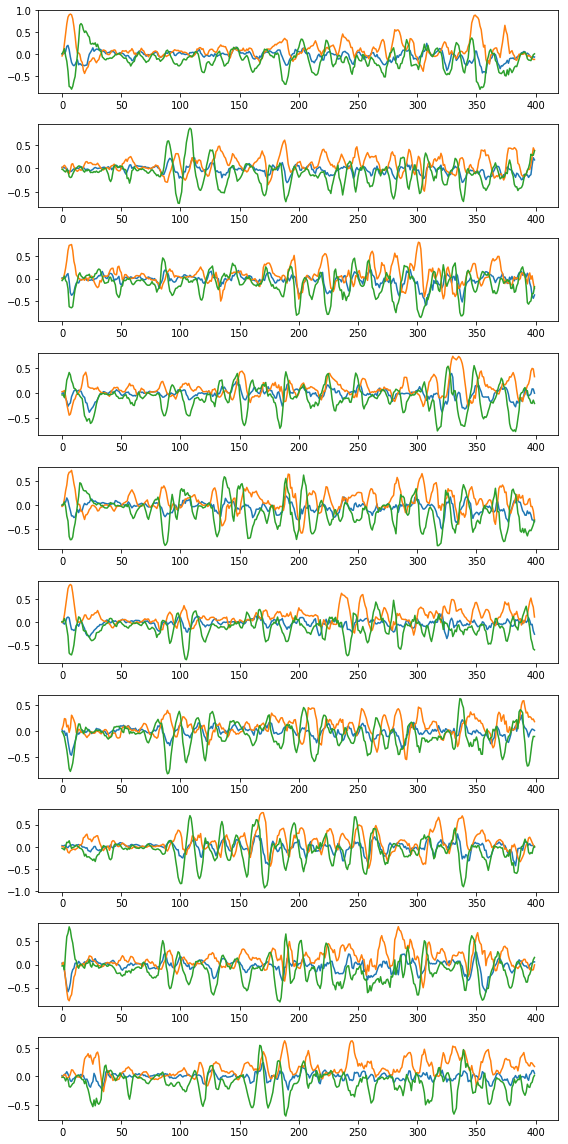

In [89]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)
visual_eval_generator(g_model)